In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import matplotlib.pyplot as plt
import npc_sessions

In [ ]:
from npc_sessions import utils
import numpy as np
import rich

In [ ]:
session = npc_sessions.DynamicRoutingSession(
    R'\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-08-03_09-39-59_670248'
    )

# Sync

In [ ]:
devices = utils.get_ephys_timing_on_pxi(session.ephys_recording_dirs)
for device in devices:
        (
            ephys_barcode_times,
            ephys_barcode_ids,
        ) = utils.extract_barcodes_from_times(
            on_times=device.ttl_sample_numbers[device.ttl_states > 0]
            / device.sampling_rate,
            off_times=device.ttl_sample_numbers[device.ttl_states < 0]
            / device.sampling_rate,
        )
        plt.plot(np.diff(ephys_barcode_times))

### barcodes

In [ ]:
full_exp_recording_dirs = [utils.get_single_oebin_path(directory).parent for directory in session.ephys_record_node_dirs]
display(tuple((device.name, device.sampling_rate, device.start_time) for device in npc_sessions.get_ephys_timing_on_sync(session.sync_path, full_exp_recording_dirs)))

get barcode intervals for each probe

In [ ]:
barcode_rising = session.sync_data.get_rising_edges(0, 'seconds')
barcode_falling = session.sync_data.get_falling_edges(0, 'seconds')
barcode_times, barcodes = utils.extract_barcodes_from_times(barcode_rising, barcode_falling)

devices_pxi = utils.get_ephys_timing_on_pxi(full_exp_recording_dirs)
devices_sync = tuple(utils.get_ephys_timing_on_sync(session.sync_path, session.ephys_recording_dirs))
device_barcode_dict = {}
for device in devices_pxi:
        if 'NI-DAQmx' in device.name or 'LFP' in device.name:
            continue
        
        device_sync = [d for d in devices_sync if d.name==device.name][0]

        (
            ephys_barcode_times,
            ephys_barcode_ids,
        ) = utils.extract_barcodes_from_times(
            on_times=device.ttl_sample_numbers[device.ttl_states > 0]
            / device.sampling_rate,
            off_times=device.ttl_sample_numbers[device.ttl_states < 0]
            / device.sampling_rate,
        )
        raw = ephys_barcode_times
        corrected = ephys_barcode_times*(30000/device_sync.sampling_rate)
        intervals = np.diff(corrected)
        max_deviation = np.max(np.abs(intervals - np.median(intervals)))

        device_barcode_dict[device.name] = {'barcode_times_raw': raw, 
                                            'barcode_times_corrected': corrected,
                                            'max_deviation_from_median_interval': max_deviation}

In [ ]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches([8, 4])
sync_intervals = np.diff(barcode_times)
sync_max_deviation_from_median_interval = np.max(np.abs(sync_intervals - np.median(sync_intervals)))
start_tag, end_tag = ('[bold green]', '[/bold green]') if sync_max_deviation_from_median_interval<0.001 else ('[bold magenta]', '[/bold magenta]')
rich.print(start_tag + 'sync:  max_deviation = ' + str(sync_max_deviation_from_median_interval) + end_tag)

ax[0].plot(sync_intervals)
legend = []
for device_name, device_data in device_barcode_dict.items():
    ax[1].plot(np.diff(device_data['barcode_times_raw']))
    ax[2].plot(np.diff(device_data['barcode_times_corrected']))
    legend.append(device_name.split('Probe')[1])
    max_deviation = device_data['max_deviation_from_median_interval']
    start_tag, end_tag = ('[bold green]', '[/bold green]') if max_deviation<0.001 else ('[bold magenta]', '[/bold magenta]')
    rich.print(start_tag + device_name + ':  max_deviation = ' + str(max_deviation) + end_tag)



ax[2].plot(sync_intervals, 'k')
ax[2].legend(legend + ['sync'])
ax[0].set_title('Sync Barcode Intervals')
ax[1].set_title('Probe Barcode Intervals')
ax[2].set_title('Probe Barcode Intervals Corrected')

plt.tight_layout()

## stim frame intervals

In [ ]:
rich.print('[bold] Fraction long frames [/bold]')
for stim_name, stim_times in stim_display_times.items():
    intervals = np.diff(stim_times)
    fraction_long = np.sum(intervals>0.02)/len(intervals)
    longest_interval = max(intervals)
    start_tag, end_tag = ('[bold green]', '[/bold green]') if fraction_long<0.01 and longest_interval<0.5 else ('[bold magenta]', '[/bold magenta]')
    rich.print(start_tag + stim_name.stem.split('_')[0] + ': ' + str(fraction_long) + ' \t\t longest interval:' + str(longest_interval) + end_tag)
    

In [ ]:
fig, axes = session.sync_data.plot_diode_measured_sync_square_flips()
stim_display_times = npc_sessions.get_stim_frame_times(*session.stim_paths, sync=session.sync_data)
names = tuple(k for k, v in stim_display_times.items() if v is not None)
for idx, ax in enumerate(axes):
    ax.set_title(names[idx].stem.split('_')[0])
fig.set_size_inches(12, 6)

In [ ]:
fig_hist, axes_hist = plt.subplots(1, len(axes))
fig_hist.set_size_inches(12, 6)

for ax, (stim_name, stim_times) in zip(axes_hist, stim_display_times.items()):
    ax.hist(np.diff(stim_times), bins=np.arange(0, 0.1, 0.001))
    ax.set_yscale('log')
    ax.axvline(1/60, c='k', ls='dotted')
    ax.set_title(stim_name.stem.split('_')[0])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('frame interval count')
plt.tight_layout()

In [ ]:
fig, axes = session.sync_data.plot_stim_onsets()
names = tuple(k for k, v in stim_display_times.items() if v is not None)
for idx, ax in enumerate(axes):
    ax.set_title(names[idx].stem.split('_')[0])
fig.set_size_inches(10, 5 * len(axes))
fig.subplots_adjust(hspace=0.3)


# MVR

In [154]:
import IPython.display

for info in session.video_info_data.values():
    print(info['CameraLabel']), display(IPython.display.JSON(
        {
            k:v
            for k,v in info.items() 
            if k in ('FPS', 'Duration', 'FramesRecorded', 'FramesLostCount')
        } | {'Lost': f"{100 * info['FramesLostCount'] / info['FramesRecorded']:.5f}%"}
    )
)

Behavior


<IPython.core.display.JSON object>

Eye


<IPython.core.display.JSON object>

Face


<IPython.core.display.JSON object>

In [147]:
video_path = session.video_paths[0]
v = cv2.VideoCapture(video_path.as_posix())

In [151]:
v.get(5)

60.0

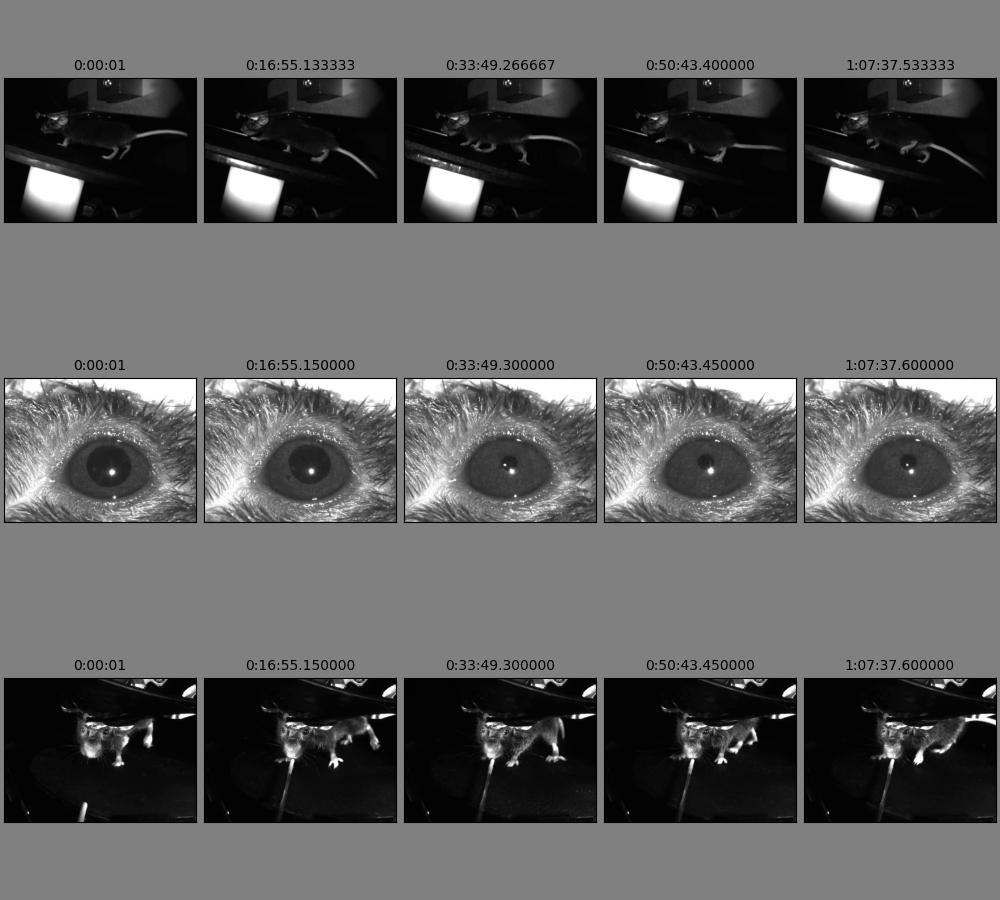

In [196]:
from typing import Iterable
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import numpy as np
import datetime
import io
from typing import Literal, TypeVar

import upath

def camera_frame_grabs_simple(
    paths: Iterable[upath.UPath],
    num_frames_to_grab: int = 5,
) -> None:
    """Just plots evenly spaced frames, no concept of epochs.
    
    video frames across cameras aren't synced .
    """
    fig = plt.figure(figsize=[10, 3 * len(paths)], constrained_layout=True, facecolor='0.5')
    gs = gridspec.GridSpec(len(paths), num_frames_to_grab, figure=fig)
    gs.update(wspace=0.0, hspace=0.0)
    for idx, video_path in enumerate(paths):
        # get frames to plot
        v = cv2.VideoCapture(video_path.as_posix()) # TODO open with upath from cloud
        
        frame_delta = np.ceil(v.get(cv2.CAP_PROP_FRAME_COUNT) / num_frames_to_grab + 1)
        frames_of_interest = np.arange(v.get(cv2.CAP_PROP_FPS), v.get(cv2.CAP_PROP_FRAME_COUNT), frame_delta)

        for i, f in enumerate(frames_of_interest):
            v.set(cv2.CAP_PROP_POS_FRAMES, int(f))
            ret, frame = v.read()
            ax = fig.add_subplot(gs[idx, i])
            ax.imshow(frame)
            # ax.axis('off')
            ax.tick_params(
                top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False,
            )
            ax.set_title(datetime.timedelta(seconds=f/v.get(cv2.CAP_PROP_FPS)), fontsize=10)
    return fig

def get_total_frames_in_video(
    paths: Iterable[upath.UPath],
    num_frames_to_grab: int = 5,
) -> dict[Literal["behavior", "eye", "face"], int]:
    frame_count_dict = {}
    for idx, video_path in enumerate(paths):
        v = cv2.VideoCapture(video_path.as_posix()) # TODO open with upath from cloud
        num_frames = v.get(cv2.CAP_PROP_FRAME_COUNT)
        cam_name = npc_sessions.extract_camera_name(video_path)
        frame_count_dict[cam_name] = int(num_frames)
    
    return frame_count_dict

fig = camera_frame_grabs_simple(session.video_paths)

## Verify frame times can be found on sync

In [ ]:
npc_sessions.get_video_frame_times(session.sync_data, *session.video_paths)

In [199]:
camera_info = {}
for info in session.video_info_data.values():
    camera_info[info['CameraLabel'].lower()] = {
        
            k:v
            for k,v in info.items() 
            if k in ('FPS', 'Duration', 'FramesRecorded', 'FramesLostCount', 'LostFrames')
        } 

In [205]:
from npc_sessions import get_cam_exposing_times_on_sync
from npc_sessions.utils.mvr import get_cam_transfer_times_on_sync
from npc_sessions.utils.mvr import get_cam_exposing_falling_edge_times_on_sync



In [206]:
cam_exposing_times = get_cam_exposing_times_on_sync(session.sync_data)
cam_transfer_times = get_cam_transfer_times_on_sync(session.sync_data)
cam_exposing_falling_edge_times = get_cam_exposing_falling_edge_times_on_sync(session.sync_data)

In [210]:
frames_in_videos = get_total_frames_in_video(session.video_paths)
for camera, info in camera_info.items():
    frames_recorded = info['FramesRecorded']
    frames_lost = info['FramesLostCount']
    num_exposures = cam_exposing_times[camera].size
    num_transfers = cam_transfer_times[camera].size

    num_frames_in_video = frames_in_videos[camera]
    num_expected_from_sync = num_transfers - frames_lost + 1
    signature_exposures = cam_exposing_falling_edge_times[camera][:10] - cam_exposing_times[camera][:10]
    
    info['num_frames_exposed'] = num_exposures
    info['num_frames_transfered'] = num_transfers
    info['num_frames_in_video'] = num_frames_in_video
    info['num_expected_from_sync'] =num_expected_from_sync
    info['expected_minus_actual'] = num_expected_from_sync - num_frames_in_video
    info['signature_exposure_duration'] = np.round(np.median(signature_exposures), 3)

In [211]:
camera_info

{'behavior': {'FPS': 60.0024,
  'Duration': '01:24:30',
  'FramesRecorded': 304232,
  'FramesLostCount': 5,
  'LostFrames': ['13-14,235575-235577'],
  'num_frames_exposed': 304233,
  'num_frames_transfered': 304233,
  'num_frames_in_video': 304233,
  'num_expected_from_sync': 304229,
  'expected_minus_actual': -4,
  'signature_exposure_duration': 0.001},
 'eye': {'FPS': 60.0024,
  'Duration': '01:24:30',
  'FramesRecorded': 304235,
  'FramesLostCount': 2,
  'LostFrames': ['13-14'],
  'num_frames_exposed': 304230,
  'num_frames_transfered': 304229,
  'num_frames_in_video': 304236,
  'num_expected_from_sync': 304228,
  'expected_minus_actual': -8,
  'signature_exposure_duration': 0.002},
 'face': {'FPS': 60.0024,
  'Duration': '01:24:30',
  'FramesRecorded': 304239,
  'FramesLostCount': 1,
  'LostFrames': ['13'],
  'num_frames_exposed': 304229,
  'num_frames_transfered': 304229,
  'num_frames_in_video': 304240,
  'num_expected_from_sync': 304229,
  'expected_minus_actual': -11,
  'signat